In [1]:

import jax
jax.config.update('jax_enable_x64',True)




In [2]:


import numpyro
from NSF import NeuralSpline1D
from flow import Normal,Flow,transform,Serial
from SkewNormalPlus import SkewNormalPlus as snp

/home/bmb41/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from jax import random
import jax_cosmo as jc
from jax_cosmo import Cosmology, background
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax.scipy.stats import norm

In [4]:

@jit
def make_training_set(key,z_s,M0=-19.5,sigma_int=0.1,h=0.7324,Om0=0.28,w=-1,mu_cut=21,sigma_cut=0.01):




    cosmo_jax = Cosmology(Omega_c=Om0, h=h, w0=w, Omega_b=0, n_s= 0.96, sigma8=200000, Omega_k=0, wa=0)

    n_sne=len(z_s)

    d_s=background.transverse_comoving_distance(cosmo_jax, 1/(1+z_s))

    mu_s=5*np.log10((1+z_s)/h*d_s*1e6/10)

    m0_s=M0+mu_s

    m_s=random.normal(key, (len(m0_s),))*sigma_int+m0_s

    key, _ = random.split(key)

    p_s=norm.cdf(-m_s, loc=-mu_cut, scale=sigma_cut)

    sel_s=random.bernoulli(key, p=p_s)

    return m0_s,m_s,sel_s


@jit
def minmax_fit_and_scale(X):
  max= np.max(X,axis=0)
  min = np.min(X,axis=0)
  X_std = (X - min) / (max-min)
  return X_std,min,max

@jit
def minmax_scale(X,min,max):
  return (X - min) / (max - min)

@jit
def minmax_unscale(X,min,max):
  return X * (max - min) + min




In [5]:
from jax.example_libraries import stax, optimizers

from jax.example_libraries.stax import (Dense, Tanh, Flatten, Relu, LogSoftmax, Softmax, Exp,Sigmoid,Softplus,LeakyRelu)

def network(rng,conditional_dim,out_dim, hidden_dim):
    init_fun,apply_fun=stax.serial(stax.Dense(hidden_dim), Relu, stax.Dense(1024),  Relu, stax.Dense(1024),Relu,stax.Dense(hidden_dim), Relu, stax.Dense(out_dim),)
    _, params = init_fun(rng, (conditional_dim,))

    return params,apply_fun
'''
def network(rng,conditional_dim,out_dim, hidden_dim):
    init_fun,apply_fun=stax.serial(stax.Dense(hidden_dim), Tanh, stax.Dense(1024),Tanh,stax.Dense(hidden_dim), Tanh, stax.Dense(out_dim),)
    _, params = init_fun(rng, (conditional_dim,))
    return params,apply_fun
'''
rng, flow_rng = random.split(random.PRNGKey(0))

init_fun = Flow(Serial(*(NeuralSpline1D(network,hidden_dim=256,K=40,B=5),)*5),prior=Normal())

params, log_pdf, sample = init_fun(flow_rng,2 )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
opt_init, opt_update, get_params = optimizers.adam(step_size=5e-3)
opt_state = opt_init(params)

In [7]:
def loss_fn(params, inputs):
    return -log_pdf(params, inputs).mean()

@jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)

    loss,gradients = value_and_grad(loss_fn)(params,inputs)
    return loss, opt_update(i, gradients, opt_state)



[3 3 3 3 3]


epoch:  0  loss:  1.3552443667597964


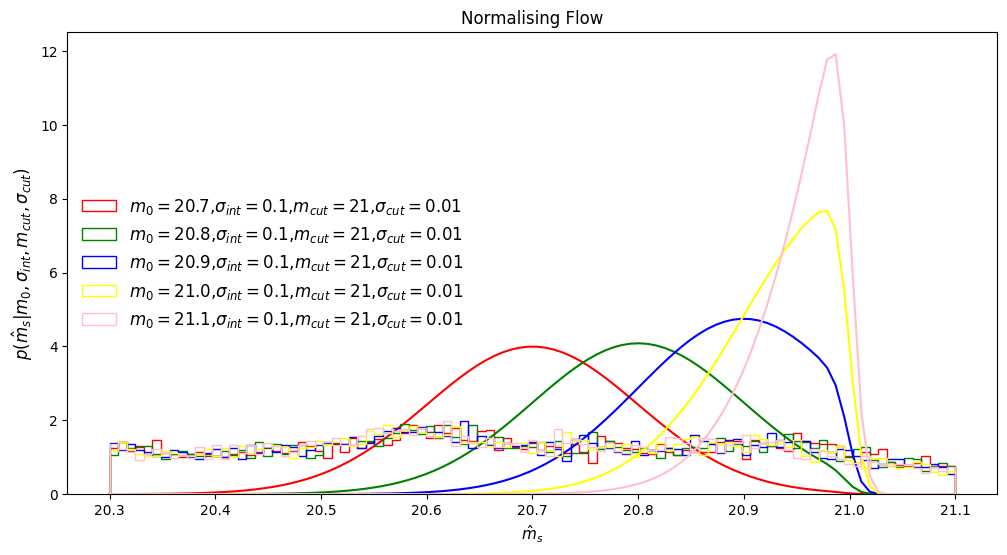

epoch:  1  loss:  1.1215450442279868
epoch:  2  loss:  0.8592734183693819
epoch:  3  loss:  0.6765427237464546
epoch:  4  loss:  0.4498651263502558
epoch:  5  loss:  0.2803385280157967
epoch:  6  loss:  0.16282326938232786
epoch:  7  loss:  -0.11463163859726186
epoch:  8  loss:  -0.1878807692006339
epoch:  9  loss:  -0.36146039895398835
epoch:  10  loss:  -0.3471143510903465
epoch:  11  loss:  -0.4934017799718059
epoch:  12  loss:  -0.5821455693021603
epoch:  13  loss:  -0.6602008278217482
epoch:  14  loss:  -0.8757764407808829
epoch:  15  loss:  -0.602791893676443
epoch:  16  loss:  -0.6766386599702466
epoch:  17  loss:  -1.0985982338423046
epoch:  18  loss:  -0.8254200334801574
epoch:  19  loss:  -0.7954167293685015
epoch:  20  loss:  -1.086110762653163
epoch:  21  loss:  -1.1912408127877097
epoch:  22  loss:  -0.7067553996795387
epoch:  23  loss:  -0.2669058106607854
epoch:  24  loss:  -0.921671688022935
epoch:  25  loss:  -0.710870611103918
epoch:  26  loss:  -0.6956269183092957
ep

epoch:  210  loss:  -0.964296629146329
epoch:  211  loss:  -1.4227180958326657
epoch:  212  loss:  -1.7666460378747038
epoch:  213  loss:  -1.4986058763983905
epoch:  214  loss:  -2.1064461449099805
epoch:  215  loss:  -1.4838655224023891
epoch:  216  loss:  -1.4890487034059396
epoch:  217  loss:  -1.4548999817617074
epoch:  218  loss:  -1.4314789806179609
epoch:  219  loss:  -1.867599365874684
epoch:  220  loss:  -0.804299779971041
epoch:  221  loss:  -1.458182835591722
epoch:  222  loss:  -2.1983713569696346
epoch:  223  loss:  -1.274520241014408
epoch:  224  loss:  -1.883229813143229
epoch:  225  loss:  -1.5911517749044257
epoch:  226  loss:  -1.2882018516661142
epoch:  227  loss:  -1.1002120826088115
epoch:  228  loss:  -1.259932789936667
epoch:  229  loss:  -1.1888044122872516
epoch:  230  loss:  -1.5319163716482498
epoch:  231  loss:  -1.8882387523290325
epoch:  232  loss:  -1.537478096145387
epoch:  233  loss:  -1.3043141986445457
epoch:  234  loss:  -1.4727330336675886
epoch:  

epoch:  416  loss:  -1.873356514106753
epoch:  417  loss:  -1.7818987876189403
epoch:  418  loss:  -1.2044836385739803
epoch:  419  loss:  -1.135617275998555
epoch:  420  loss:  -1.2440116220461575
epoch:  421  loss:  -1.2084188427849294
epoch:  422  loss:  -1.3440269380664835
epoch:  423  loss:  -2.185858962476203
epoch:  424  loss:  -1.1787842793114762
epoch:  425  loss:  -1.7210292953010637
epoch:  426  loss:  -1.606748115734027
epoch:  427  loss:  -1.5648111260323034
epoch:  428  loss:  -1.225868281617548
epoch:  429  loss:  -1.4670421592574012
epoch:  430  loss:  -1.7184164600742606
epoch:  431  loss:  -1.297842422478886
epoch:  432  loss:  -1.1189721548455853
epoch:  433  loss:  -0.9632692002571317
epoch:  434  loss:  -1.3535380585935586
epoch:  435  loss:  -1.485033823548472
epoch:  436  loss:  -1.1128382992409815
epoch:  437  loss:  -1.5069921702557878
epoch:  438  loss:  -1.385416541251879
epoch:  439  loss:  -1.5149620148451142
epoch:  440  loss:  -1.2277305035029429
epoch:  

epoch:  623  loss:  -1.433109337234252
epoch:  624  loss:  -1.5079692453056648
epoch:  625  loss:  -1.7367255140348246
epoch:  626  loss:  -1.1838677197197367
epoch:  627  loss:  -1.4013615991612955
epoch:  628  loss:  -1.8392594551621921
epoch:  629  loss:  -1.6861899784307908
epoch:  630  loss:  -1.8963015316856466
epoch:  631  loss:  -1.6528869096360614
epoch:  632  loss:  -1.8729255922923083
epoch:  633  loss:  -1.8460501844302446
epoch:  634  loss:  -1.3260423943870614
epoch:  635  loss:  -1.44882874395416
epoch:  636  loss:  -1.135418003733076
epoch:  637  loss:  -1.1324342244098926
epoch:  638  loss:  -1.4672890575937099
epoch:  639  loss:  -1.6770555825601603
epoch:  640  loss:  -1.7149788348183819
epoch:  641  loss:  -1.1557686413219932
epoch:  642  loss:  -1.8716819624578382
epoch:  643  loss:  -1.5640768536481728
epoch:  644  loss:  -1.531387728183372
epoch:  645  loss:  -1.6890000673610157
epoch:  646  loss:  -1.4260198760963871
epoch:  647  loss:  -1.182482699702479
epoch:

epoch:  829  loss:  -1.2954185189835532
epoch:  830  loss:  -1.7595802843640094
epoch:  831  loss:  -1.2854535621177305
epoch:  832  loss:  -1.1336246355936086
epoch:  833  loss:  -1.446714972703984
epoch:  834  loss:  -1.4570369402751437
epoch:  835  loss:  -1.4561402099468905
epoch:  836  loss:  -0.9575415762255888
epoch:  837  loss:  -1.4739729174974145
epoch:  838  loss:  -1.4109341843799517
epoch:  839  loss:  -1.1852496596595163
epoch:  840  loss:  -1.8455064475994902
epoch:  841  loss:  -1.3069179313430694
epoch:  842  loss:  -1.338281442379441
epoch:  843  loss:  -1.4697307842337235
epoch:  844  loss:  -1.6441588977188453
epoch:  845  loss:  -1.5690363146694646
epoch:  846  loss:  -1.937986170634313
epoch:  847  loss:  -1.940358172794012
epoch:  848  loss:  -1.3769654022481255
epoch:  849  loss:  -1.6918870415667437
epoch:  850  loss:  -1.3608825465372871
epoch:  851  loss:  -1.5202069799126872
epoch:  852  loss:  -1.2962145024293859
epoch:  853  loss:  -1.9252583132963015
epoc

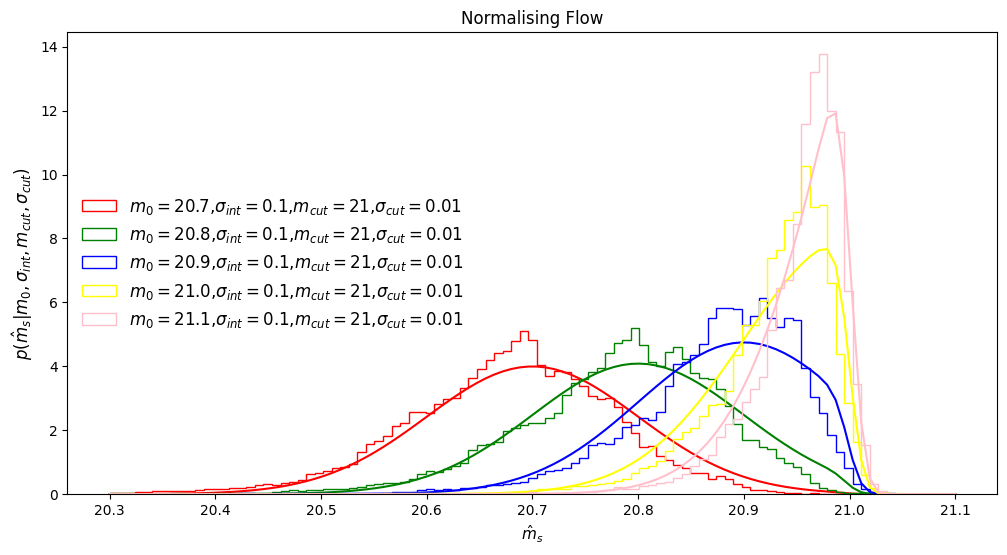

epoch:  1001  loss:  -1.2077744002280133
epoch:  1002  loss:  -1.8559808230088182
epoch:  1003  loss:  -1.185779604761327
epoch:  1004  loss:  -1.5028746297226674
epoch:  1005  loss:  -1.6648471094407324
epoch:  1006  loss:  -1.961207951180668
epoch:  1007  loss:  -1.3780186619321986
epoch:  1008  loss:  -1.5802591734148492
epoch:  1009  loss:  -1.8522517507596234
epoch:  1010  loss:  -2.1369347853309146
epoch:  1011  loss:  -1.8719497007451993
epoch:  1012  loss:  -1.1679877053358354
epoch:  1013  loss:  -1.5288139230856177
epoch:  1014  loss:  -1.4231167379958574
epoch:  1015  loss:  -1.6944018061560269
epoch:  1016  loss:  -1.3742091382691446
epoch:  1017  loss:  -1.533043548349888
epoch:  1018  loss:  -1.752411399066346
epoch:  1019  loss:  -1.8172324348320144
epoch:  1020  loss:  -1.4061586015466787
epoch:  1021  loss:  -1.6339576558056306
epoch:  1022  loss:  -1.3765261229538805
epoch:  1023  loss:  -1.15785758885317
epoch:  1024  loss:  -1.7727686378210683
epoch:  1025  loss:  -

epoch:  1202  loss:  -1.662357862981701
epoch:  1203  loss:  -1.3949088823625464
epoch:  1204  loss:  -1.5108614003075087
epoch:  1205  loss:  -1.5392685374739676
epoch:  1206  loss:  -1.899103607375868
epoch:  1207  loss:  -1.5755835427647176
epoch:  1208  loss:  -1.775071029232381
epoch:  1209  loss:  -1.1478597216765178
epoch:  1210  loss:  -1.3576194870209206
epoch:  1211  loss:  -1.8938139430853103
epoch:  1212  loss:  -1.473832297264271
epoch:  1213  loss:  -1.1601259436439695
epoch:  1214  loss:  -1.534851363414734
epoch:  1215  loss:  -1.3101037527873722
epoch:  1216  loss:  -1.4570241703844682
epoch:  1217  loss:  -1.363117646119034
epoch:  1218  loss:  -1.378469397215761
epoch:  1219  loss:  -1.988990397559448
epoch:  1220  loss:  -1.3924532818624444
epoch:  1221  loss:  -1.4005704901959857
epoch:  1222  loss:  -1.3921352394124125
epoch:  1223  loss:  -1.4399893560239
epoch:  1224  loss:  -1.6609904560317807
epoch:  1225  loss:  -1.1164163133528309
epoch:  1226  loss:  -1.727

epoch:  1403  loss:  -1.6058154837130953
epoch:  1404  loss:  -1.332338505778316
epoch:  1405  loss:  -1.7588523762395458
epoch:  1406  loss:  -1.3058425095688193
epoch:  1407  loss:  -1.7914696220824475
epoch:  1408  loss:  -1.5070443107230067
epoch:  1409  loss:  -1.6734065265506608
epoch:  1410  loss:  -2.1195157908909814
epoch:  1411  loss:  -1.1426988546477832
epoch:  1412  loss:  -2.1239649423528943
epoch:  1413  loss:  -1.7181685985619353
epoch:  1414  loss:  -1.554923928636927
epoch:  1415  loss:  -1.7414434871342361
epoch:  1416  loss:  -1.9067881584768143
epoch:  1417  loss:  -1.6564407995333463
epoch:  1418  loss:  -2.315032387166044
epoch:  1419  loss:  -1.2061521000874416
epoch:  1420  loss:  -1.5907068719844255
epoch:  1421  loss:  -1.5175071767473398
epoch:  1422  loss:  -1.8528678300630677
epoch:  1423  loss:  -1.7200613289758713
epoch:  1424  loss:  -1.3968380846448452
epoch:  1425  loss:  -1.1954808585730354
epoch:  1426  loss:  -1.420636604999348
epoch:  1427  loss: 

epoch:  1605  loss:  -1.9572935356377654
epoch:  1606  loss:  -1.3896064360038585
epoch:  1607  loss:  -1.827933987538679
epoch:  1608  loss:  -1.4381266841536713
epoch:  1609  loss:  -1.3647715713679742
epoch:  1610  loss:  -1.4687909804121009
epoch:  1611  loss:  -1.8385874749773725
epoch:  1612  loss:  -1.6986437627554103
epoch:  1613  loss:  -1.8919073476343615
epoch:  1614  loss:  -1.3678450068644332
epoch:  1615  loss:  -1.3202876334537537
epoch:  1616  loss:  -1.203571851976305
epoch:  1617  loss:  -1.640478814485715
epoch:  1618  loss:  -2.2192693102214758
epoch:  1619  loss:  -2.131635422599451
epoch:  1620  loss:  -1.2226487985414742
epoch:  1621  loss:  -1.618062579442369
epoch:  1622  loss:  -1.7507747778107867
epoch:  1623  loss:  -1.4384421573127983
epoch:  1624  loss:  -1.3076699541025092
epoch:  1625  loss:  -1.4628568710449221
epoch:  1626  loss:  -1.4048552536022203
epoch:  1627  loss:  -1.4965700533587267
epoch:  1628  loss:  -2.0281938860454916
epoch:  1629  loss:  

epoch:  1807  loss:  -1.344225350909046
epoch:  1808  loss:  -0.8849901780094992
epoch:  1809  loss:  -1.8691518896547343
epoch:  1810  loss:  -2.1491845454235974
epoch:  1811  loss:  -1.6279706541449066
epoch:  1812  loss:  -1.3177691523597534
epoch:  1813  loss:  -1.981613267927546
epoch:  1814  loss:  -1.5896695896706992
epoch:  1815  loss:  -1.3866210961431338
epoch:  1816  loss:  -1.5242306175567428
epoch:  1817  loss:  -1.1411144092444294
epoch:  1818  loss:  -1.465540336296932
epoch:  1819  loss:  -1.6599064163531594
epoch:  1820  loss:  -1.2993134555969088
epoch:  1821  loss:  -1.9053382644329717
epoch:  1822  loss:  -1.5897205683082423
epoch:  1823  loss:  -1.196355381462443
epoch:  1824  loss:  -1.03154783973043
epoch:  1825  loss:  -1.639760680847588
epoch:  1826  loss:  -1.642438605872445
epoch:  1827  loss:  -1.8456387090023658
epoch:  1828  loss:  -1.6411566616843103
epoch:  1829  loss:  -1.5815417962596967
epoch:  1830  loss:  -1.600658586060606
epoch:  1831  loss:  -1.5

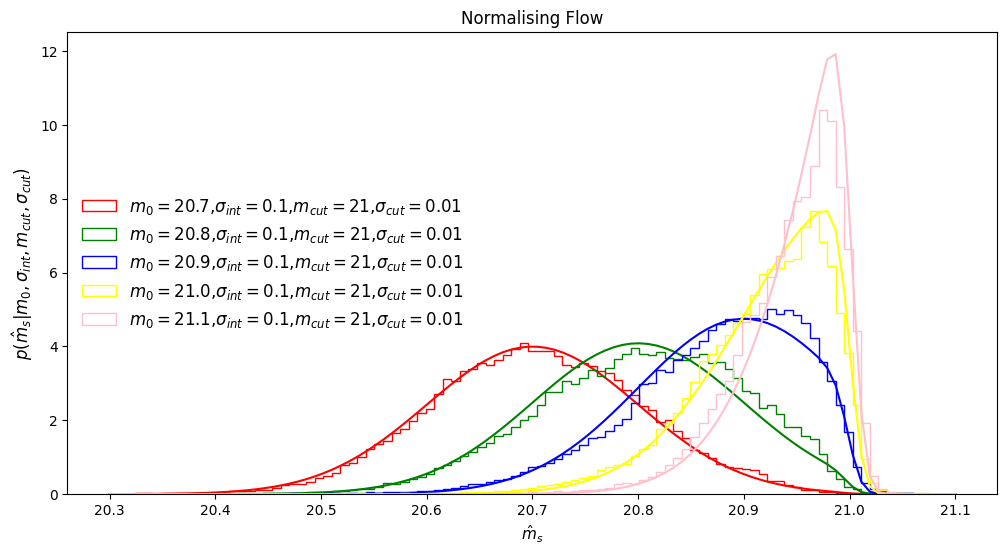

epoch:  2001  loss:  -1.2974444466297474
epoch:  2002  loss:  -1.8956191449667055
epoch:  2003  loss:  -1.0329655219498255
epoch:  2004  loss:  -1.6428919619811873
epoch:  2005  loss:  -1.1226874385332077
epoch:  2006  loss:  -1.7556351857806178
epoch:  2007  loss:  -1.781499681073623
epoch:  2008  loss:  -1.394810027601712
epoch:  2009  loss:  -1.3908813319453315
epoch:  2010  loss:  -1.123697794390536
epoch:  2011  loss:  -1.4216710224703493
epoch:  2012  loss:  -2.4314707729551763
epoch:  2013  loss:  -1.2669619675379926
epoch:  2014  loss:  -1.2643502424815292
epoch:  2015  loss:  -1.6096045850935234
epoch:  2016  loss:  -1.9127302874403878
epoch:  2017  loss:  -1.476135414145447
epoch:  2018  loss:  -1.3059886788435133
epoch:  2019  loss:  -1.5761152523147122
epoch:  2020  loss:  -1.2822250604034453
epoch:  2021  loss:  -1.7077886628366687
epoch:  2022  loss:  -1.4072346214614087
epoch:  2023  loss:  -1.6309657650521006
epoch:  2024  loss:  -1.7459427533117393
epoch:  2025  loss: 

epoch:  2203  loss:  -1.7877907887364826
epoch:  2204  loss:  -1.4886929381717928
epoch:  2205  loss:  -1.5974062286576423
epoch:  2206  loss:  -1.755865329880133
epoch:  2207  loss:  -1.4490437762814155
epoch:  2208  loss:  -2.0983369297501406
epoch:  2209  loss:  -1.694812225616212
epoch:  2210  loss:  -1.7338349695583661
epoch:  2211  loss:  -1.934592557509887
epoch:  2212  loss:  -1.128103670428102
epoch:  2213  loss:  -1.6664343003724733
epoch:  2214  loss:  -1.902896663541624
epoch:  2215  loss:  -1.4092516217277733
epoch:  2216  loss:  -2.368528058913478
epoch:  2217  loss:  -1.9534744424161905
epoch:  2218  loss:  -1.5755520545214445
epoch:  2219  loss:  -1.4672266846255388
epoch:  2220  loss:  -1.793702212390906
epoch:  2221  loss:  -1.1636095197039455
epoch:  2222  loss:  -2.163636973938211
epoch:  2223  loss:  -1.9245754547069231
epoch:  2224  loss:  -2.3346991139347093
epoch:  2225  loss:  -1.7158919616790558
epoch:  2226  loss:  -1.8119271373453611
epoch:  2227  loss:  -1.

epoch:  2404  loss:  -1.1283798922916732
epoch:  2405  loss:  -2.056916604975431
epoch:  2406  loss:  -2.0142032332474438
epoch:  2407  loss:  -1.496389844002205
epoch:  2408  loss:  -1.5585487775028273
epoch:  2409  loss:  -1.1394971354380259
epoch:  2410  loss:  -1.2796887722385035
epoch:  2411  loss:  -1.8256838073918593
epoch:  2412  loss:  -1.6799808631778657
epoch:  2413  loss:  -1.6075960140129406
epoch:  2414  loss:  -1.4627382587452662
epoch:  2415  loss:  -1.5401489219295372
epoch:  2416  loss:  -1.5062713410465303
epoch:  2417  loss:  -1.752005697819353
epoch:  2418  loss:  -1.5299045112155063
epoch:  2419  loss:  -1.3728614935604389
epoch:  2420  loss:  -1.6953062775746326
epoch:  2421  loss:  -1.6185884554585297
epoch:  2422  loss:  -1.6916582339553825
epoch:  2423  loss:  -1.8948544964320668
epoch:  2424  loss:  -1.2178260900374838
epoch:  2425  loss:  -1.5743691316027881
epoch:  2426  loss:  -1.4360722616184884
epoch:  2427  loss:  -1.8537594572117297
epoch:  2428  loss:

epoch:  2606  loss:  -1.6676631940765
epoch:  2607  loss:  -1.328280072483131
epoch:  2608  loss:  -1.9310912015100081
epoch:  2609  loss:  -1.4348955226194555
epoch:  2610  loss:  -1.173433403332871
epoch:  2611  loss:  -1.3608924815534151
epoch:  2612  loss:  -1.4782183411021383
epoch:  2613  loss:  -1.4192049538154503
epoch:  2614  loss:  -1.8996947560957247
epoch:  2615  loss:  -1.490274258344391
epoch:  2616  loss:  -1.4724492698081044
epoch:  2617  loss:  -1.5455931756229042
epoch:  2618  loss:  -2.01551207464949
epoch:  2619  loss:  -1.0180920912656133
epoch:  2620  loss:  -1.7269062295579785
epoch:  2621  loss:  -2.042583042681149
epoch:  2622  loss:  -2.0596919405778116
epoch:  2623  loss:  -2.1997929546424393
epoch:  2624  loss:  -1.9633280952069627
epoch:  2625  loss:  -1.8217863447562723
epoch:  2626  loss:  -2.111109943934078
epoch:  2627  loss:  -1.985440123399127
epoch:  2628  loss:  -1.465851052258949
epoch:  2629  loss:  -1.7335523133090638
epoch:  2630  loss:  -1.4657

epoch:  2808  loss:  -1.7472591179573451
epoch:  2809  loss:  -1.8166786553116396
epoch:  2810  loss:  -2.0078121619847913
epoch:  2811  loss:  -1.8717178955423341
epoch:  2812  loss:  -1.3444336019446896
epoch:  2813  loss:  -1.6341265191663243
epoch:  2814  loss:  -1.3769480120815185
epoch:  2815  loss:  -1.686389925300697
epoch:  2816  loss:  -1.544390296024033
epoch:  2817  loss:  -1.621677052553752
epoch:  2818  loss:  -1.2914543325394439
epoch:  2819  loss:  -2.7475798803580287
epoch:  2820  loss:  -1.5762637370140222
epoch:  2821  loss:  -2.3005429326663243
epoch:  2822  loss:  -0.9548076858680576
epoch:  2823  loss:  -1.1736297842131742
epoch:  2824  loss:  -1.0881953918054172
epoch:  2825  loss:  -1.0270563787119023
epoch:  2826  loss:  -1.4191927909898514
epoch:  2827  loss:  -1.0528127252931687
epoch:  2828  loss:  -1.7405508582702165
epoch:  2829  loss:  -1.1210184875329947
epoch:  2830  loss:  -1.068345497797805
epoch:  2831  loss:  -1.08843478780035
epoch:  2832  loss:  -

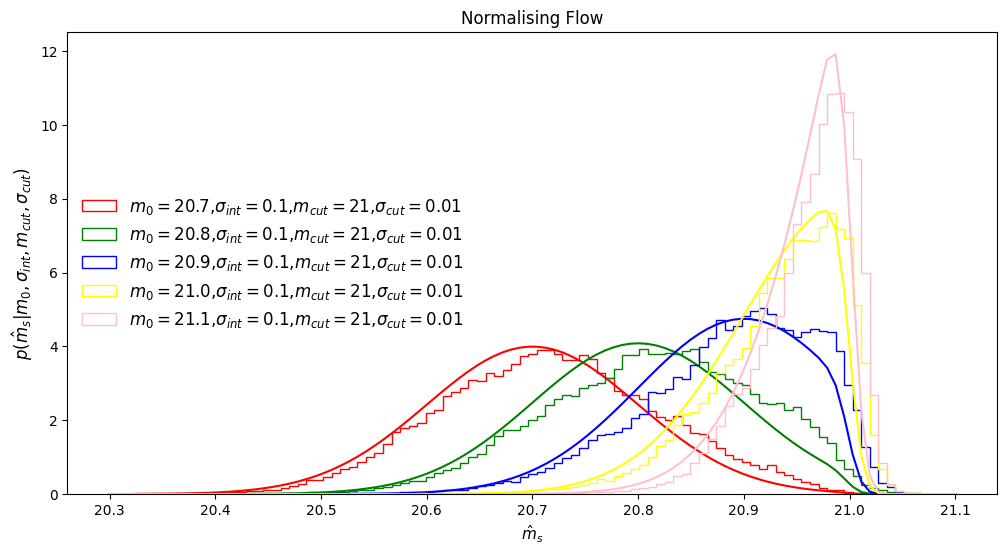

epoch:  3001  loss:  -1.4411336859633908
epoch:  3002  loss:  -1.3585741955469106
epoch:  3003  loss:  -1.4983676783435498
epoch:  3004  loss:  -1.7417439579147194
epoch:  3005  loss:  -1.8715919894613
epoch:  3006  loss:  -1.4384309231924968
epoch:  3007  loss:  -1.5397799534134142
epoch:  3008  loss:  -1.6454896054704065
epoch:  3009  loss:  -1.6936615460347721
epoch:  3010  loss:  -0.8808560989321734
epoch:  3011  loss:  -1.3030611847098106
epoch:  3012  loss:  -1.201915450225035
epoch:  3013  loss:  -1.3807031403740997
epoch:  3014  loss:  -1.5236445063901847
epoch:  3015  loss:  -2.1051467238636627
epoch:  3016  loss:  -1.8968306413407054
epoch:  3017  loss:  -1.4952672999318386
epoch:  3018  loss:  -1.7188799750615633
epoch:  3019  loss:  -1.4345376317957503
epoch:  3020  loss:  -1.4131040870613625
epoch:  3021  loss:  -1.8798493448397517
epoch:  3022  loss:  -1.646439034044546
epoch:  3023  loss:  -1.6440805560295848
epoch:  3024  loss:  -1.7826997286389887
epoch:  3025  loss:  

epoch:  3203  loss:  -1.680830432539845
epoch:  3204  loss:  -1.3507013840530127
epoch:  3205  loss:  -1.6314845072550421
epoch:  3206  loss:  -1.7506252016526391
epoch:  3207  loss:  -1.0673690816819104
epoch:  3208  loss:  -1.315629603804051
epoch:  3209  loss:  -1.4800578733989056
epoch:  3210  loss:  -1.2129953901684556
epoch:  3211  loss:  -1.5740149394805572
epoch:  3212  loss:  -1.2534807229581424
epoch:  3213  loss:  -1.464256499155619
epoch:  3214  loss:  -1.3128502800911652
epoch:  3215  loss:  -1.5766362260645386
epoch:  3216  loss:  -1.7974051330978518
epoch:  3217  loss:  -1.565729622372493
epoch:  3218  loss:  -1.7711381782938538
epoch:  3219  loss:  -1.3333334034309001
epoch:  3220  loss:  -1.2749849013871524
epoch:  3221  loss:  -1.6089494715850088
epoch:  3222  loss:  -1.4465947311880862
epoch:  3223  loss:  -1.7708115880107762
epoch:  3224  loss:  -1.7596893624968142
epoch:  3225  loss:  -1.9849870508316139
epoch:  3226  loss:  -1.945846921658873
epoch:  3227  loss:  

epoch:  3405  loss:  -1.3377269443419084
epoch:  3406  loss:  -1.6359886255481793
epoch:  3407  loss:  -1.5732521382897044
epoch:  3408  loss:  -1.7085731137746452
epoch:  3409  loss:  -1.4440794023105035
epoch:  3410  loss:  -1.3147020378105199
epoch:  3411  loss:  -1.4559895358249255
epoch:  3412  loss:  -1.9105528892048818
epoch:  3413  loss:  -1.203551149157527
epoch:  3414  loss:  -2.2336293367220823
epoch:  3415  loss:  -1.3950054930617695
epoch:  3416  loss:  -1.6736474258543181
epoch:  3417  loss:  -1.350709286363985
epoch:  3418  loss:  -1.6842911651594705
epoch:  3419  loss:  -1.2259459493474292
epoch:  3420  loss:  -1.7521102958419106
epoch:  3421  loss:  -1.1982286706202767
epoch:  3422  loss:  -1.4772177118620542
epoch:  3423  loss:  -1.1156171592459065
epoch:  3424  loss:  -1.528977193556305
epoch:  3425  loss:  -1.8244451202354162
epoch:  3426  loss:  -1.5220970175080795
epoch:  3427  loss:  -1.8760982213581157
epoch:  3428  loss:  -1.6650867033943488
epoch:  3429  loss:

epoch:  3607  loss:  -1.8507556328655084
epoch:  3608  loss:  -2.323309561375187
epoch:  3609  loss:  -1.3981027364165044
epoch:  3610  loss:  -1.7856675796206531
epoch:  3611  loss:  -1.2935703892290966
epoch:  3612  loss:  -1.5631060138929715
epoch:  3613  loss:  -1.609782580185964
epoch:  3614  loss:  -1.6921056746093464
epoch:  3615  loss:  -1.1966924861211254
epoch:  3616  loss:  -1.348597779747142
epoch:  3617  loss:  -1.4143488003013374
epoch:  3618  loss:  -1.450476780615944
epoch:  3619  loss:  -1.4336538049988576
epoch:  3620  loss:  -1.623168850377313
epoch:  3621  loss:  -2.136559294470281
epoch:  3622  loss:  -1.3042837835702281
epoch:  3623  loss:  -1.425947242329171
epoch:  3624  loss:  -1.3078017334420458
epoch:  3625  loss:  -2.1655987474686618
epoch:  3626  loss:  -1.6156054424001272
epoch:  3627  loss:  -1.448466403147575
epoch:  3628  loss:  -1.8830470077509298
epoch:  3629  loss:  -1.9326167999553487
epoch:  3630  loss:  -1.9606325211820836
epoch:  3631  loss:  -1.

epoch:  3809  loss:  -1.3595870787171687
epoch:  3810  loss:  -1.6424321244509448
epoch:  3811  loss:  -1.5524218740485212
epoch:  3812  loss:  -1.1227798193571799
epoch:  3813  loss:  -1.9087676965565583
epoch:  3814  loss:  -1.5931677593676195
epoch:  3815  loss:  -1.6840963853872566
epoch:  3816  loss:  -1.929533247374559
epoch:  3817  loss:  -1.6130685802827789
epoch:  3818  loss:  -1.96738904981923
epoch:  3819  loss:  -1.649564126484293
epoch:  3820  loss:  -1.2666666047425907
epoch:  3821  loss:  -1.2185334733210902
epoch:  3822  loss:  -2.000875196349638
epoch:  3823  loss:  -1.5480112100670378
epoch:  3824  loss:  -1.735165040299252
epoch:  3825  loss:  -1.2480017858020724
epoch:  3826  loss:  -1.5306798939903683
epoch:  3827  loss:  -1.5161805030829991
epoch:  3828  loss:  -2.288066140474937
epoch:  3829  loss:  -1.4845857556387623
epoch:  3830  loss:  -1.295064072442042
epoch:  3831  loss:  -1.4657961836707583
epoch:  3832  loss:  -1.4946878224273368
epoch:  3833  loss:  -1.

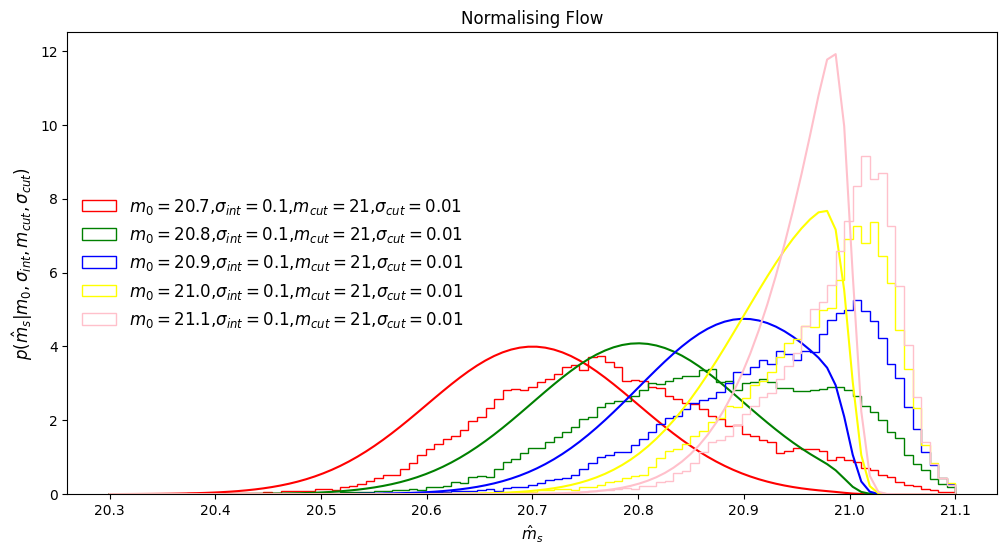

epoch:  4001  loss:  -1.444966615510809
epoch:  4002  loss:  -1.5495552096062384
epoch:  4003  loss:  -1.0992332640015725
epoch:  4004  loss:  -0.782291467831745
epoch:  4005  loss:  -1.573748999556114
epoch:  4006  loss:  -1.5723785793259404
epoch:  4007  loss:  -1.733234694264444
epoch:  4008  loss:  -1.5346209261084804
epoch:  4009  loss:  -1.4876584204098653
epoch:  4010  loss:  -1.6117139407315686
epoch:  4011  loss:  -1.438729278933874
epoch:  4012  loss:  -1.5815856247053002
epoch:  4013  loss:  -1.1034916520225193
epoch:  4014  loss:  -1.5944574610829405
epoch:  4015  loss:  -1.1268284109543616
epoch:  4016  loss:  -1.1710452411441452
epoch:  4017  loss:  -1.1885958998026582
epoch:  4018  loss:  -1.3655146066068709
epoch:  4019  loss:  -1.3432423453228413
epoch:  4020  loss:  -1.3355100676293215
epoch:  4021  loss:  -1.169316460345628
epoch:  4022  loss:  -1.1946727191586564
epoch:  4023  loss:  -1.1287561198668759
epoch:  4024  loss:  -1.4472045671981224
epoch:  4025  loss:  -

epoch:  4203  loss:  -1.5822045560796343
epoch:  4204  loss:  -1.537851680945985
epoch:  4205  loss:  -1.1163047558165065
epoch:  4206  loss:  -1.4974526817451161
epoch:  4207  loss:  -1.6013605567556315
epoch:  4208  loss:  -1.7516222123611707
epoch:  4209  loss:  -2.446588551937718
epoch:  4210  loss:  -1.5748344369348273
epoch:  4211  loss:  -1.5977774980671986
epoch:  4212  loss:  -1.505884721062375
epoch:  4213  loss:  -1.3505080821971676
epoch:  4214  loss:  -1.4442079698034358
epoch:  4215  loss:  -1.7506970795775547
epoch:  4216  loss:  -1.4945308222426628
epoch:  4217  loss:  -1.6530152954346655
epoch:  4218  loss:  -1.9572566296416603
epoch:  4219  loss:  -1.8331417013568576
epoch:  4220  loss:  -1.8224415730599757
epoch:  4221  loss:  -1.697362552524888
epoch:  4222  loss:  -1.278767819048265
epoch:  4223  loss:  -1.421355310266234
epoch:  4224  loss:  -1.921194936938865
epoch:  4225  loss:  -1.202463654963225
epoch:  4226  loss:  -1.731640259541119
epoch:  4227  loss:  -1.9

epoch:  4405  loss:  -1.7330625971626825
epoch:  4406  loss:  -1.9020739352820633
epoch:  4407  loss:  -1.8176909617101547
epoch:  4408  loss:  -1.1042072480726326
epoch:  4409  loss:  -1.490485635928679
epoch:  4410  loss:  -1.4808877074746096
epoch:  4411  loss:  -1.6532969295639506
epoch:  4412  loss:  -1.5068529045442933
epoch:  4413  loss:  -2.2251809284135575
epoch:  4414  loss:  -1.9246244075401429
epoch:  4415  loss:  -1.3344794873474155
epoch:  4416  loss:  -1.3950083643311801
epoch:  4417  loss:  -2.377679652833213
epoch:  4418  loss:  -2.21660356263688
epoch:  4419  loss:  -1.3771598313780862
epoch:  4420  loss:  -1.51318844710793
epoch:  4421  loss:  -1.6757794102658654
epoch:  4422  loss:  -1.5442215528029024
epoch:  4423  loss:  -1.8793469716089755
epoch:  4424  loss:  -1.9824540016127066
epoch:  4425  loss:  -1.9912876065300489
epoch:  4426  loss:  -1.8752584919058428
epoch:  4427  loss:  -2.100371815247418
epoch:  4428  loss:  -1.445708976068132
epoch:  4429  loss:  -1.

epoch:  4607  loss:  -1.4083589104733356
epoch:  4608  loss:  -2.0962811175104945
epoch:  4609  loss:  -2.169483493770507
epoch:  4610  loss:  -1.4173913372229208
epoch:  4611  loss:  -1.5850744233060465
epoch:  4612  loss:  -1.6852826180969207
epoch:  4613  loss:  -1.782759909394791
epoch:  4614  loss:  -1.4342266434946
epoch:  4615  loss:  -1.543918797113663
epoch:  4616  loss:  -1.3287806051878321
epoch:  4617  loss:  -1.5684272472986982
epoch:  4618  loss:  -2.212107759353466
epoch:  4619  loss:  -1.1910363289851789
epoch:  4620  loss:  -1.6399102028761532
epoch:  4621  loss:  -1.7636000223752815
epoch:  4622  loss:  -1.8201038893823642
epoch:  4623  loss:  -1.705544554867177
epoch:  4624  loss:  -1.0370402112774681
epoch:  4625  loss:  -1.712582034702214
epoch:  4626  loss:  -1.9152478495159413
epoch:  4627  loss:  -1.4562816044473683
epoch:  4628  loss:  -1.28576597234038
epoch:  4629  loss:  -1.3430370353194678
epoch:  4630  loss:  -1.9828792573333258
epoch:  4631  loss:  -1.590

epoch:  4809  loss:  -1.5474920811294106
epoch:  4810  loss:  -1.8192941499228394
epoch:  4811  loss:  -2.602169485347058
epoch:  4812  loss:  -2.6303687974185492
epoch:  4813  loss:  -1.2869688654019618
epoch:  4814  loss:  -2.040007851180461
epoch:  4815  loss:  -1.5167001994992935
epoch:  4816  loss:  -1.8989896286406611
epoch:  4817  loss:  -1.7923099403412364
epoch:  4818  loss:  -1.4594661825658193
epoch:  4819  loss:  -2.0075509065282184
epoch:  4820  loss:  -1.2780574896498307
epoch:  4821  loss:  -1.6567991646083489
epoch:  4822  loss:  -1.8169497233867766
epoch:  4823  loss:  -1.6451990666850953
epoch:  4824  loss:  -1.8012552905305457
epoch:  4825  loss:  -1.7837068078845004
epoch:  4826  loss:  -1.3471052724285884
epoch:  4827  loss:  -1.4598176371882041
epoch:  4828  loss:  -1.185524089547211
epoch:  4829  loss:  -0.9727150686742783
epoch:  4830  loss:  -1.1850857238888202
epoch:  4831  loss:  -2.1252883737119133
epoch:  4832  loss:  -2.3962554453663287
epoch:  4833  loss:

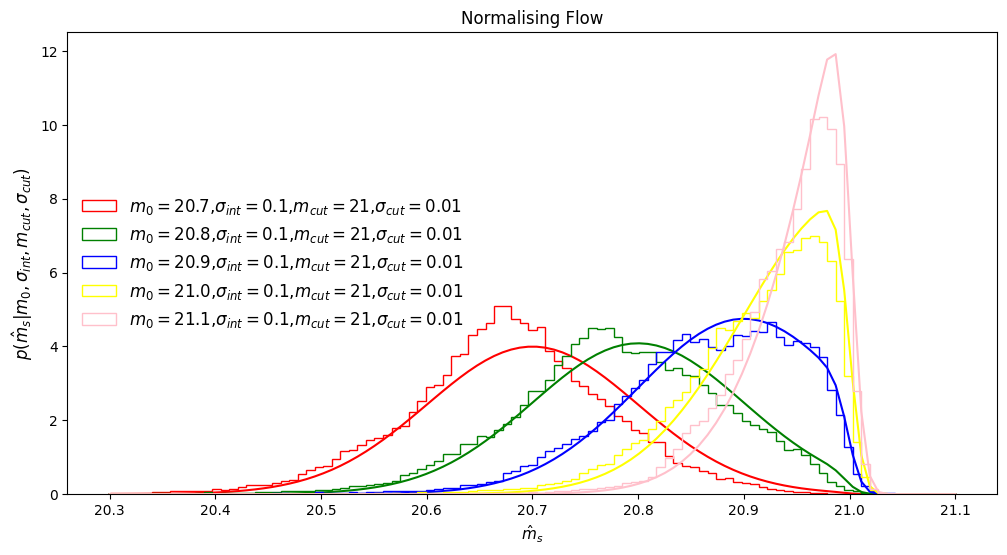

epoch:  5001  loss:  -1.688252127595878
epoch:  5002  loss:  -1.3351418589215236
epoch:  5003  loss:  -1.6590432727009048
epoch:  5004  loss:  -1.5167509273347837
epoch:  5005  loss:  -1.6347914069077083
epoch:  5006  loss:  -1.2246812848062953
epoch:  5007  loss:  -1.6827009567706286
epoch:  5008  loss:  -1.9885813730533402
epoch:  5009  loss:  -1.55425802329268
epoch:  5010  loss:  -1.3377079173681992
epoch:  5011  loss:  -1.4830144799865157
epoch:  5012  loss:  -1.3614132161517516
epoch:  5013  loss:  -1.7750169206915112
epoch:  5014  loss:  -1.2698796422151533
epoch:  5015  loss:  -1.7139206404078469
epoch:  5016  loss:  -1.4373476674717411
epoch:  5017  loss:  -1.656648738236702
epoch:  5018  loss:  -1.367950189933317
epoch:  5019  loss:  -1.973429590612178
epoch:  5020  loss:  -1.713116313023061
epoch:  5021  loss:  -2.0043617201845336
epoch:  5022  loss:  -1.2125832569408883
epoch:  5023  loss:  -1.4398165271537078
epoch:  5024  loss:  -2.0745450926451374
epoch:  5025  loss:  -1

epoch:  5203  loss:  -1.8068559833219227
epoch:  5204  loss:  -1.3892127305452837
epoch:  5205  loss:  -1.6873234695400035
epoch:  5206  loss:  -1.9918048067052394
epoch:  5207  loss:  -1.6349300702354486
epoch:  5208  loss:  -1.17677828141202
epoch:  5209  loss:  -1.3414585262541878
epoch:  5210  loss:  -1.7280396721410793
epoch:  5211  loss:  -1.6001647225748665
epoch:  5212  loss:  -1.31690951102226
epoch:  5213  loss:  -2.0295307498880812
epoch:  5214  loss:  -1.9384876948428882
epoch:  5215  loss:  -1.1911778665336206
epoch:  5216  loss:  -1.8934898427237195
epoch:  5217  loss:  -1.366631808563955
epoch:  5218  loss:  -1.5440136108960445
epoch:  5219  loss:  -1.4795326826470556
epoch:  5220  loss:  -1.5192847662768296
epoch:  5221  loss:  -1.6204145431460473
epoch:  5222  loss:  -1.638029422009527
epoch:  5223  loss:  -1.8091748171718478
epoch:  5224  loss:  -1.812171406188358
epoch:  5225  loss:  -2.097197165123322
epoch:  5226  loss:  -1.886216869903787
epoch:  5227  loss:  -1.6

epoch:  5405  loss:  -1.1428698204614207
epoch:  5406  loss:  -1.5252348064893892
epoch:  5407  loss:  -1.2952361435079696
epoch:  5408  loss:  -1.5377452416820312
epoch:  5409  loss:  -1.2795663430888067
epoch:  5410  loss:  -2.1163921854443735
epoch:  5411  loss:  -1.6924419197194738
epoch:  5412  loss:  -1.2643517054886222
epoch:  5413  loss:  -1.9278797431581571
epoch:  5414  loss:  -2.2442841825778235
epoch:  5415  loss:  -1.0677261484985556
epoch:  5416  loss:  -1.9463195572423901
epoch:  5417  loss:  -1.9657653945759088
epoch:  5418  loss:  -1.841601585194643
epoch:  5419  loss:  -1.4906815686914503
epoch:  5420  loss:  -1.42649114217665
epoch:  5421  loss:  -1.275321628398749
epoch:  5422  loss:  -1.844759683715109
epoch:  5423  loss:  -1.1577414595024744
epoch:  5424  loss:  -1.8960840727171162
epoch:  5425  loss:  -2.0456751702959
epoch:  5426  loss:  -1.1933183341827072
epoch:  5427  loss:  -1.3244736959655838
epoch:  5428  loss:  -1.695359911407363
epoch:  5429  loss:  -1.7

epoch:  5607  loss:  -1.1927557498327441
epoch:  5608  loss:  -1.5094160015739344
epoch:  5609  loss:  -1.9164485272148317
epoch:  5610  loss:  -1.9725573479178138
epoch:  5611  loss:  -1.5455820355356946
epoch:  5612  loss:  -1.8672775587292518
epoch:  5613  loss:  -1.5935378584610522
epoch:  5614  loss:  -1.632096182148846
epoch:  5615  loss:  -1.4830192384278194
epoch:  5616  loss:  -1.553634562691175
epoch:  5617  loss:  -2.181320804433807
epoch:  5618  loss:  -1.8504781527976892
epoch:  5619  loss:  -1.5366309411486447
epoch:  5620  loss:  -1.528973643501814
epoch:  5621  loss:  -1.7700477936544634
epoch:  5622  loss:  -1.7403534182199034
epoch:  5623  loss:  -1.8964747620236062
epoch:  5624  loss:  -1.3958453478234283
epoch:  5625  loss:  -1.591997187777959
epoch:  5626  loss:  -2.1483861359957044
epoch:  5627  loss:  -1.108564748223452
epoch:  5628  loss:  -1.3468969244160194
epoch:  5629  loss:  -1.3037654346948966
epoch:  5630  loss:  -1.9651663131942527
epoch:  5631  loss:  -

epoch:  5808  loss:  -1.6231200148091198
epoch:  5809  loss:  -1.0463011067227028
epoch:  5810  loss:  -1.8997709902328306
epoch:  5811  loss:  -1.2304231099484033
epoch:  5812  loss:  -1.0110272897569434
epoch:  5813  loss:  -1.592334578184964
epoch:  5814  loss:  -2.012638187944976
epoch:  5815  loss:  -1.2377010888534348
epoch:  5816  loss:  -1.341654570798892
epoch:  5817  loss:  -1.2844510313633841
epoch:  5818  loss:  -1.3798729166253625
epoch:  5819  loss:  -2.1812814641220375
epoch:  5820  loss:  -1.8485973523933494
epoch:  5821  loss:  -1.4846460978405869
epoch:  5822  loss:  -1.5938773801455843
epoch:  5823  loss:  -1.7953545425933013
epoch:  5824  loss:  -1.6176732806566576
epoch:  5825  loss:  -1.227840555843614
epoch:  5826  loss:  -1.1244835840866105
epoch:  5827  loss:  -1.331199624497356
epoch:  5828  loss:  -1.1261607011213541
epoch:  5829  loss:  -1.6316576919629442
epoch:  5830  loss:  -1.5578718234379851
epoch:  5831  loss:  -1.581066352158919
epoch:  5832  loss:  -

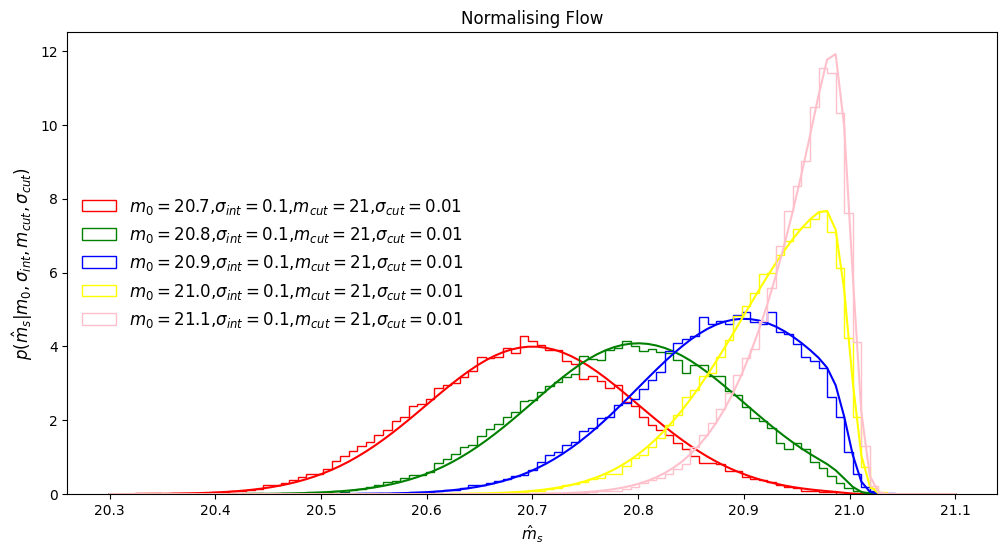

epoch:  6001  loss:  -1.926547590813641
epoch:  6002  loss:  -2.1674769720563347
epoch:  6003  loss:  -1.0391031032822866
epoch:  6004  loss:  -1.6310584485065283
epoch:  6005  loss:  -1.1089581186854855
epoch:  6006  loss:  -1.2214725165134475
epoch:  6007  loss:  -1.2889186251559008
epoch:  6008  loss:  -1.466360460096154
epoch:  6009  loss:  -2.0598966702949473
epoch:  6010  loss:  -2.202992378309017
epoch:  6011  loss:  -1.5986777925851852
epoch:  6012  loss:  -2.176643910826937
epoch:  6013  loss:  -1.907042504635008
epoch:  6014  loss:  -1.459868091510587
epoch:  6015  loss:  -1.487892648905116
epoch:  6016  loss:  -1.454730356538232
epoch:  6017  loss:  -1.7439123690426366
epoch:  6018  loss:  -1.3879366172864047
epoch:  6019  loss:  -1.256860257348555
epoch:  6020  loss:  -1.291990978052208
epoch:  6021  loss:  -1.4423706335839122
epoch:  6022  loss:  -1.411508748355156
epoch:  6023  loss:  -1.3280876475311671
epoch:  6024  loss:  -1.9409215041393637
epoch:  6025  loss:  -1.699

epoch:  6203  loss:  -1.6965574770539726
epoch:  6204  loss:  -0.6746744962490975
epoch:  6205  loss:  -1.577325673470198
epoch:  6206  loss:  -1.3267594543920418
epoch:  6207  loss:  -1.6183793005882305
epoch:  6208  loss:  -1.6293545644741523
epoch:  6209  loss:  -1.288725439912265
epoch:  6210  loss:  -1.5026840959159498
epoch:  6211  loss:  -1.3775711667774426
epoch:  6212  loss:  -1.5920302937154767
epoch:  6213  loss:  -1.9209609476347376
epoch:  6214  loss:  -1.9640314509817431
epoch:  6215  loss:  -1.303438821805788
epoch:  6216  loss:  -1.4867349624321893
epoch:  6217  loss:  -1.7062309133643523
epoch:  6218  loss:  -1.450792607681001
epoch:  6219  loss:  -1.7758048662866732
epoch:  6220  loss:  -1.5035562654210346
epoch:  6221  loss:  -1.256884977509226
epoch:  6222  loss:  -2.142042036774271
epoch:  6223  loss:  -1.5628750250795493
epoch:  6224  loss:  -2.0033827994934112
epoch:  6225  loss:  -2.1090700633094883
epoch:  6226  loss:  -2.0218465688978653
epoch:  6227  loss:  -

epoch:  6404  loss:  -1.1888749521919169
epoch:  6405  loss:  -1.8282146435663953
epoch:  6406  loss:  -1.0850414520659801
epoch:  6407  loss:  -2.0915642890496393
epoch:  6408  loss:  -1.6462317724772375
epoch:  6409  loss:  -1.4420312916580913
epoch:  6410  loss:  -1.0724783454559288
epoch:  6411  loss:  -1.0023801151314582
epoch:  6412  loss:  -1.3515954940797517
epoch:  6413  loss:  -1.789796760234038
epoch:  6414  loss:  -1.6708264689165493
epoch:  6415  loss:  -1.7610848838156474
epoch:  6416  loss:  -1.496301214163705
epoch:  6417  loss:  -1.3932941647723696
epoch:  6418  loss:  -1.7771136572476032
epoch:  6419  loss:  -1.733531357597578
epoch:  6420  loss:  -2.048128224728794
epoch:  6421  loss:  -1.7863628390793307
epoch:  6422  loss:  -1.72805764690946
epoch:  6423  loss:  -1.4580861127269762
epoch:  6424  loss:  -0.9441280984159057
epoch:  6425  loss:  -1.717753120519692
epoch:  6426  loss:  -1.4249940321526133
epoch:  6427  loss:  -2.0043252642080427
epoch:  6428  loss:  -1

epoch:  6606  loss:  -1.7484413582912255
epoch:  6607  loss:  -1.5057090634177004
epoch:  6608  loss:  -1.686423475502093
epoch:  6609  loss:  -1.2872037520117237
epoch:  6610  loss:  -1.4624562815964646
epoch:  6611  loss:  -1.9451823227636253
epoch:  6612  loss:  -1.2291794445392243
epoch:  6613  loss:  -1.4534561935492916
epoch:  6614  loss:  -1.50131510977289
epoch:  6615  loss:  -2.3647715276406034
epoch:  6616  loss:  -1.215868450438144
epoch:  6617  loss:  -2.1083454324076167
epoch:  6618  loss:  -1.554011890508134
epoch:  6619  loss:  -1.6876932261768167
epoch:  6620  loss:  -1.693783935808488
epoch:  6621  loss:  -1.6022985427526986
epoch:  6622  loss:  -2.021749038462646
epoch:  6623  loss:  -1.543726516530227
epoch:  6624  loss:  -1.941848518035683
epoch:  6625  loss:  -2.067427053719259
epoch:  6626  loss:  -1.3543888521394751
epoch:  6627  loss:  -2.1144778373605937
epoch:  6628  loss:  -1.2449501040483688
epoch:  6629  loss:  -2.1435557223207344
epoch:  6630  loss:  -1.70

epoch:  6808  loss:  -1.5594364801947245
epoch:  6809  loss:  -1.2779516344932094
epoch:  6810  loss:  -1.840547278346003
epoch:  6811  loss:  -2.2960353282087946
epoch:  6812  loss:  -1.2858820230044374
epoch:  6813  loss:  -1.0864195535812868
epoch:  6814  loss:  -1.3457230605453256
epoch:  6815  loss:  -1.4183230080049296
epoch:  6816  loss:  -1.5888603875971485
epoch:  6817  loss:  -1.3358555579246418
epoch:  6818  loss:  -1.9129879561282794
epoch:  6819  loss:  -1.8331762841307329
epoch:  6820  loss:  -1.510369576724384
epoch:  6821  loss:  -1.7680139539711641
epoch:  6822  loss:  -1.7615195703750635
epoch:  6823  loss:  -1.9142484176985315
epoch:  6824  loss:  -1.3941519861678113
epoch:  6825  loss:  -1.029918718358088
epoch:  6826  loss:  -1.293097638436911
epoch:  6827  loss:  -1.6809131142689115
epoch:  6828  loss:  -1.3096634726240193
epoch:  6829  loss:  -1.4051770209561925
epoch:  6830  loss:  -1.6833321583406404
epoch:  6831  loss:  -1.3688761976009327
epoch:  6832  loss: 

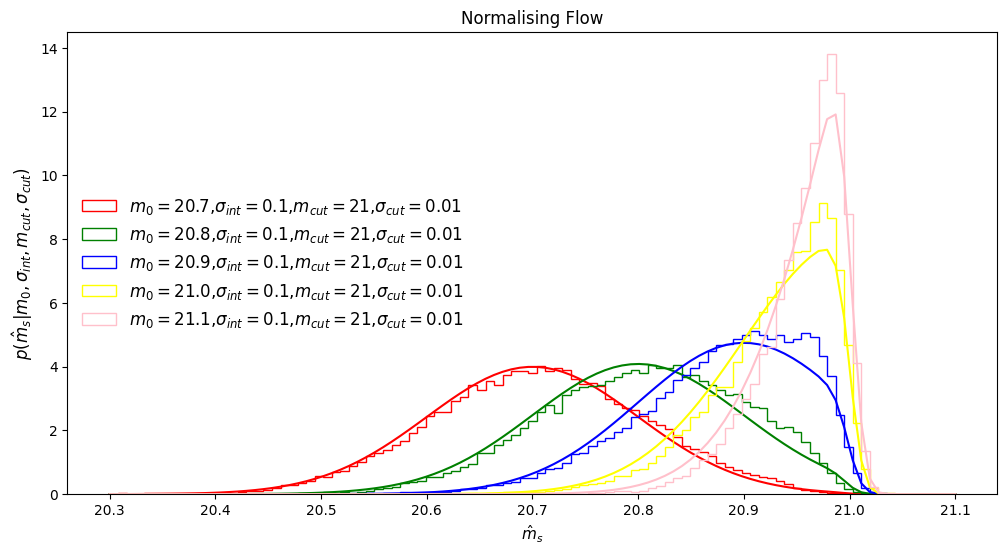

epoch:  7001  loss:  -0.9019401748254958
epoch:  7002  loss:  -1.281168736863853
epoch:  7003  loss:  -2.0085539669570798
epoch:  7004  loss:  -1.6374453180259776
epoch:  7005  loss:  -2.2448258864224337
epoch:  7006  loss:  -1.7419633878507776
epoch:  7007  loss:  -1.0530531998959423
epoch:  7008  loss:  -1.7721090962107178
epoch:  7009  loss:  -1.7109100917015398
epoch:  7010  loss:  -1.3024615937118493
epoch:  7011  loss:  -1.5155267365792606
epoch:  7012  loss:  -1.6505767665362558
epoch:  7013  loss:  -1.2296464501230526
epoch:  7014  loss:  -0.9858017668315642
epoch:  7015  loss:  -1.583974162297
epoch:  7016  loss:  -1.1505867277507658
epoch:  7017  loss:  -1.429760028705704
epoch:  7018  loss:  -2.188606849137151
epoch:  7019  loss:  -2.1953999331209415
epoch:  7020  loss:  -1.794347429038567
epoch:  7021  loss:  -1.5440294655806899
epoch:  7022  loss:  -1.3884347247097237
epoch:  7023  loss:  -2.674396134081557
epoch:  7024  loss:  -1.6354810783953329
epoch:  7025  loss:  -2.1

epoch:  7203  loss:  -1.2153416708052869
epoch:  7204  loss:  -1.572637010297452
epoch:  7205  loss:  -1.4874461127796303
epoch:  7206  loss:  -0.8680867524580169
epoch:  7207  loss:  -1.1041623509507001
epoch:  7208  loss:  -1.725789427638361
epoch:  7209  loss:  -1.3326364966087036
epoch:  7210  loss:  -1.2204257673041656
epoch:  7211  loss:  -1.5127587774449853
epoch:  7212  loss:  -1.13014132103343
epoch:  7213  loss:  -1.5286851483657167
epoch:  7214  loss:  -1.3628248875701408
epoch:  7215  loss:  -1.3324800321501375
epoch:  7216  loss:  -1.0816418392633522
epoch:  7217  loss:  -1.4429758370077839
epoch:  7218  loss:  -1.7954025749261042
epoch:  7219  loss:  -1.3919917383057692
epoch:  7220  loss:  -1.9950447103444924
epoch:  7221  loss:  -1.20577228359133
epoch:  7222  loss:  -1.130990972166556
epoch:  7223  loss:  -1.767426582038318
epoch:  7224  loss:  -1.534785352749974
epoch:  7225  loss:  -0.9909093224398818
epoch:  7226  loss:  -1.9458717507394427
epoch:  7227  loss:  -2.1

epoch:  7405  loss:  -1.9028795398432472
epoch:  7406  loss:  -1.7558324159533778
epoch:  7407  loss:  -1.5555478684912671
epoch:  7408  loss:  -2.533355546565634
epoch:  7409  loss:  -1.5581144098101518
epoch:  7410  loss:  -1.7409899188516034
epoch:  7411  loss:  -1.8265014546155545
epoch:  7412  loss:  -2.1741001579945816
epoch:  7413  loss:  -1.635635572302373
epoch:  7414  loss:  -1.8320727225925757
epoch:  7415  loss:  -1.774728681556881
epoch:  7416  loss:  -1.738052534865104
epoch:  7417  loss:  -1.5823404421190632
epoch:  7418  loss:  -1.2368727711528615
epoch:  7419  loss:  -1.3962018203771234
epoch:  7420  loss:  -1.7083983271326257
epoch:  7421  loss:  -1.7115852402006322
epoch:  7422  loss:  -1.271897035062721
epoch:  7423  loss:  -2.0235600092774413
epoch:  7424  loss:  -2.1397829532533206
epoch:  7425  loss:  -1.5958512694619813
epoch:  7426  loss:  -1.5981069286701317
epoch:  7427  loss:  -1.7891011079166794
epoch:  7428  loss:  -1.7494013818122047
epoch:  7429  loss:  

epoch:  7607  loss:  -1.5845454729263226
epoch:  7608  loss:  -1.7005589362018412
epoch:  7609  loss:  -1.6319425986214624
epoch:  7610  loss:  -1.687197084831986
epoch:  7611  loss:  -1.3811968976357782
epoch:  7612  loss:  -1.8378325509219833
epoch:  7613  loss:  -1.4508819368798522
epoch:  7614  loss:  -1.686118400880578
epoch:  7615  loss:  -1.356414179510535
epoch:  7616  loss:  -1.4715147170503202
epoch:  7617  loss:  -2.341302048083956
epoch:  7618  loss:  -1.7860245451804304
epoch:  7619  loss:  -1.6537844891311855
epoch:  7620  loss:  -1.508810212583625
epoch:  7621  loss:  -1.2886470485819181
epoch:  7622  loss:  -2.3029436208500162
epoch:  7623  loss:  -1.5001799139822902
epoch:  7624  loss:  -2.109509439861192
epoch:  7625  loss:  -1.590049243900408
epoch:  7626  loss:  -1.4051211467150235
epoch:  7627  loss:  -1.6809154535377158
epoch:  7628  loss:  -2.3706403374890472
epoch:  7629  loss:  -1.6617497977526585
epoch:  7630  loss:  -1.1589154830981494
epoch:  7631  loss:  -2

epoch:  7809  loss:  -1.5099423118927984
epoch:  7810  loss:  -1.3728754549092352
epoch:  7811  loss:  -1.6530787306310273
epoch:  7812  loss:  -1.6292143897340043
epoch:  7813  loss:  -1.4475647056116565
epoch:  7814  loss:  -1.8283780015156652
epoch:  7815  loss:  -1.7528971549350514
epoch:  7816  loss:  -1.5424931756210578
epoch:  7817  loss:  -1.4321711453384864
epoch:  7818  loss:  -1.1051673630108043
epoch:  7819  loss:  -1.8743756075551388
epoch:  7820  loss:  -1.1522818889512254
epoch:  7821  loss:  -2.1409026684690997
epoch:  7822  loss:  -1.622375414298105
epoch:  7823  loss:  -1.9829891821699581
epoch:  7824  loss:  -0.9675746795974643
epoch:  7825  loss:  -1.5086122509414241
epoch:  7826  loss:  -2.5627354480050752
epoch:  7827  loss:  -1.4156920742339751
epoch:  7828  loss:  -2.1234346565190134
epoch:  7829  loss:  -1.0785013542711759
epoch:  7830  loss:  -1.8465614825775152
epoch:  7831  loss:  -1.5020743145946411
epoch:  7832  loss:  -1.635350580907882
epoch:  7833  loss

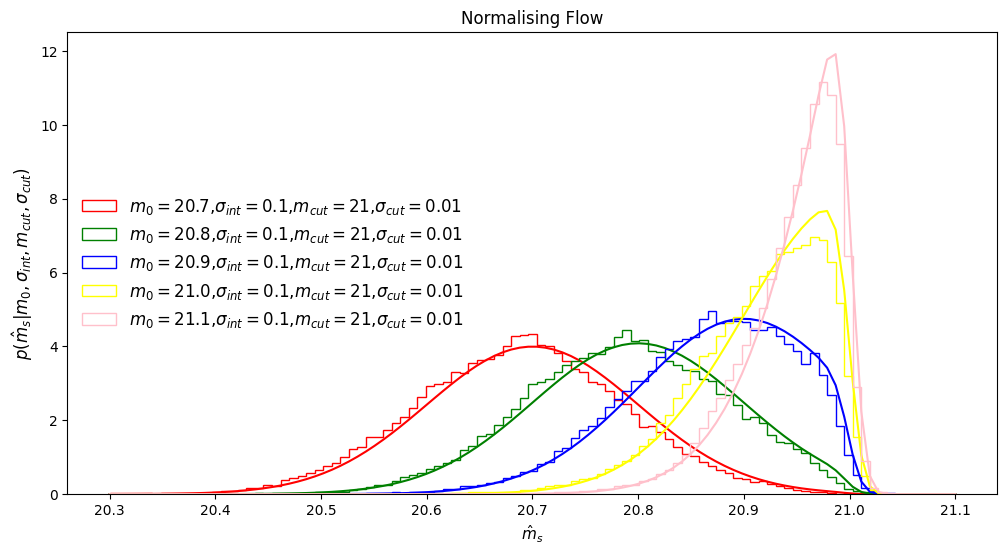

epoch:  8001  loss:  -1.2384944446985082
epoch:  8002  loss:  -1.1650393923112417
epoch:  8003  loss:  -1.6587774962993214
epoch:  8004  loss:  -1.539898568970501
epoch:  8005  loss:  -1.8293883615586388
epoch:  8006  loss:  -1.3617474356572012
epoch:  8007  loss:  -1.257720926560753
epoch:  8008  loss:  -1.161731202975277
epoch:  8009  loss:  -1.4869882920562654
epoch:  8010  loss:  -1.393368934843012
epoch:  8011  loss:  -1.8166896643333954
epoch:  8012  loss:  -1.6143686240486013
epoch:  8013  loss:  -1.447571139359973
epoch:  8014  loss:  -1.3216003809835182
epoch:  8015  loss:  -1.8656562162970258
epoch:  8016  loss:  -1.8451532905191317
epoch:  8017  loss:  -1.6782795157213235
epoch:  8018  loss:  -2.052138350222184
epoch:  8019  loss:  -1.47509235134847
epoch:  8020  loss:  -1.1136013986317916
epoch:  8021  loss:  -1.3435526462383591
epoch:  8022  loss:  -1.306361632821749
epoch:  8023  loss:  -1.2510434106801944
epoch:  8024  loss:  -1.4603261720459095
epoch:  8025  loss:  -1.8

epoch:  8203  loss:  -1.3880376900841944
epoch:  8204  loss:  -1.3015877701482783
epoch:  8205  loss:  -1.2299984007048421
epoch:  8206  loss:  -1.7944573252454177
epoch:  8207  loss:  -1.6103667971914224
epoch:  8208  loss:  -2.1774026596506535
epoch:  8209  loss:  -1.2028937125518961
epoch:  8210  loss:  -1.5500023667318115
epoch:  8211  loss:  -1.7140504186067411
epoch:  8212  loss:  -1.5597350378147503
epoch:  8213  loss:  -1.7722190289510766
epoch:  8214  loss:  -1.586307834997831
epoch:  8215  loss:  -1.6771800903549996
epoch:  8216  loss:  -2.0510993916788887
epoch:  8217  loss:  -1.5934098490749098
epoch:  8218  loss:  -1.627252390451628
epoch:  8219  loss:  -1.513982339657679
epoch:  8220  loss:  -1.7785077238515843
epoch:  8221  loss:  -1.7725126645642568
epoch:  8222  loss:  -1.022339365097596
epoch:  8223  loss:  -1.4734863741548834
epoch:  8224  loss:  -2.0489980095753535
epoch:  8225  loss:  -1.284506236072592
epoch:  8226  loss:  -1.8121936147792694
epoch:  8227  loss:  

epoch:  8405  loss:  -2.1894041564254594
epoch:  8406  loss:  -1.3352751882481084
epoch:  8407  loss:  -1.6409768157603477
epoch:  8408  loss:  -1.732746074760198
epoch:  8409  loss:  -1.550099597862726
epoch:  8410  loss:  -1.4417491438406844
epoch:  8411  loss:  -1.7042176862334386
epoch:  8412  loss:  -2.3559797409079586
epoch:  8413  loss:  -1.2113006859852484
epoch:  8414  loss:  -1.2503861262058509
epoch:  8415  loss:  -1.0727597276147895
epoch:  8416  loss:  -1.3172173259541058
epoch:  8417  loss:  -1.3692129584007309
epoch:  8418  loss:  -0.9241159944965798
epoch:  8419  loss:  -1.643079983386278
epoch:  8420  loss:  -1.5090934083477325
epoch:  8421  loss:  -1.1940501659948555
epoch:  8422  loss:  -1.4828718431543135
epoch:  8423  loss:  -1.2557687151095933
epoch:  8424  loss:  -0.9080306122414927
epoch:  8425  loss:  -2.104802548984785
epoch:  8426  loss:  -1.5487765759154841
epoch:  8427  loss:  -1.5187715206234553
epoch:  8428  loss:  -1.392023096810518
epoch:  8429  loss:  

epoch:  8607  loss:  -1.4215117766991503
epoch:  8608  loss:  -1.8093835603872863
epoch:  8609  loss:  -1.6798010189263428
epoch:  8610  loss:  -1.4426801694168425
epoch:  8611  loss:  -1.8535913096558256
epoch:  8612  loss:  -1.7126493554986324
epoch:  8613  loss:  -1.7346895470225818
epoch:  8614  loss:  -1.1191202276332783
epoch:  8615  loss:  -1.887830083318092
epoch:  8616  loss:  -1.6857900339257466
epoch:  8617  loss:  -1.636038883343275
epoch:  8618  loss:  -1.2864809802901278
epoch:  8619  loss:  -1.9576583939207879
epoch:  8620  loss:  -1.7474716573057012
epoch:  8621  loss:  -1.7892082012613768
epoch:  8622  loss:  -1.3675802624572282
epoch:  8623  loss:  -1.524997443489673
epoch:  8624  loss:  -1.9228382117358598
epoch:  8625  loss:  -2.046295813971711
epoch:  8626  loss:  -1.644585275067319
epoch:  8627  loss:  -1.7741907133826522
epoch:  8628  loss:  -1.5214192882223825
epoch:  8629  loss:  -2.7973522786875566
epoch:  8630  loss:  -2.1474197047345895
epoch:  8631  loss:  

epoch:  8809  loss:  -1.8401282463901512
epoch:  8810  loss:  -1.4482679243094763
epoch:  8811  loss:  -2.043682771919037
epoch:  8812  loss:  -1.1688365676157284
epoch:  8813  loss:  -1.6013357173838179
epoch:  8814  loss:  -1.3343613969159407
epoch:  8815  loss:  -1.3336137357226359
epoch:  8816  loss:  -2.2754117999268484
epoch:  8817  loss:  -1.8015550954199522
epoch:  8818  loss:  -1.6343143780479303
epoch:  8819  loss:  -1.146575366718678
epoch:  8820  loss:  -2.3629257098824246
epoch:  8821  loss:  -1.2334637686834828
epoch:  8822  loss:  -1.5961493967807743
epoch:  8823  loss:  -1.1405372604938846
epoch:  8824  loss:  -1.3029052294802663
epoch:  8825  loss:  -1.9664593891781452
epoch:  8826  loss:  -1.5769972402924881
epoch:  8827  loss:  -1.369677265424374
epoch:  8828  loss:  -1.000774023138844
epoch:  8829  loss:  -1.4556285106525126
epoch:  8830  loss:  -1.39807186391094
epoch:  8831  loss:  -1.861602416516775
epoch:  8832  loss:  -2.542438336374875
epoch:  8833  loss:  -2.

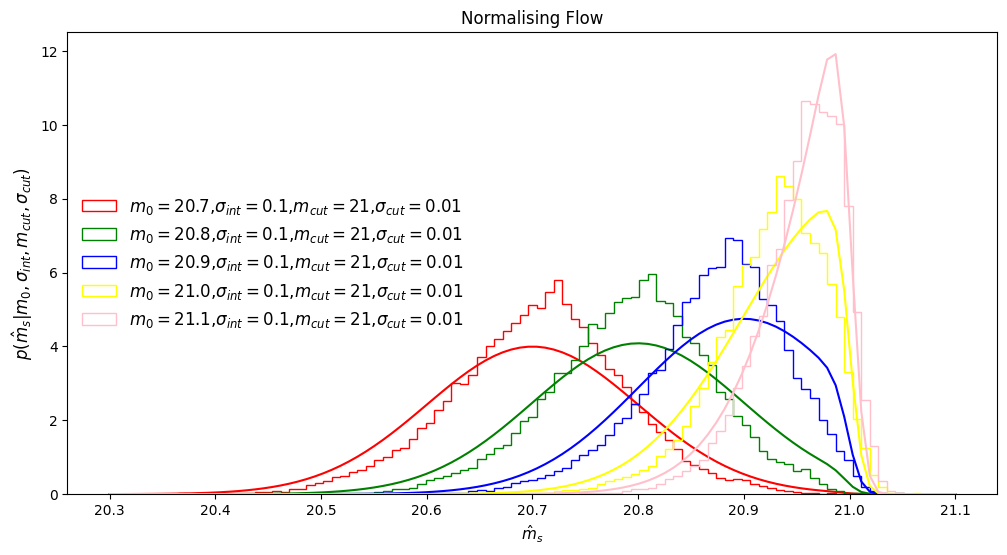

epoch:  9001  loss:  -1.187592570171101
epoch:  9002  loss:  -1.7849816706836976
epoch:  9003  loss:  -2.0044128593931743
epoch:  9004  loss:  -1.6664073670003834
epoch:  9005  loss:  -1.566145910288654
epoch:  9006  loss:  -2.0402254803012623
epoch:  9007  loss:  -1.967174117261873
epoch:  9008  loss:  -1.029117339013228
epoch:  9009  loss:  -1.7561503910988954
epoch:  9010  loss:  -2.4374525709579924
epoch:  9011  loss:  -1.6661199387322143
epoch:  9012  loss:  -1.2210678465948877
epoch:  9013  loss:  -1.620391402416115
epoch:  9014  loss:  -1.574152517237798
epoch:  9015  loss:  -1.8664133478134612
epoch:  9016  loss:  -1.8920170322831829
epoch:  9017  loss:  -1.6134744723305203
epoch:  9018  loss:  -1.8127621028972312
epoch:  9019  loss:  -1.3471877814585855
epoch:  9020  loss:  -1.3722383411749077
epoch:  9021  loss:  -2.0923603510859716
epoch:  9022  loss:  -1.7019532949972436
epoch:  9023  loss:  -1.587731237898491
epoch:  9024  loss:  -1.4035958380330558
epoch:  9025  loss:  -1

epoch:  9203  loss:  -0.888411230144367
epoch:  9204  loss:  -0.8927661128208098
epoch:  9205  loss:  -1.7523677598906404
epoch:  9206  loss:  -1.2071849534102457
epoch:  9207  loss:  -2.001880687231831
epoch:  9208  loss:  -1.5141041630027066
epoch:  9209  loss:  -1.8091246340233944
epoch:  9210  loss:  -1.3150143863133825
epoch:  9211  loss:  -1.3085995209709465
epoch:  9212  loss:  -1.9019210197517598
epoch:  9213  loss:  -1.2740173783617779
epoch:  9214  loss:  -1.762522976061504
epoch:  9215  loss:  -1.82606056588008
epoch:  9216  loss:  -2.7684253567817496
epoch:  9217  loss:  -1.6874070884555505
epoch:  9218  loss:  -1.1757557031535704
epoch:  9219  loss:  -1.5010226000516316
epoch:  9220  loss:  -1.3963760194484593
epoch:  9221  loss:  -1.3324282392304585
epoch:  9222  loss:  -1.0259015669248535
epoch:  9223  loss:  -0.5413137594944597
epoch:  9224  loss:  -1.2961764509213527
epoch:  9225  loss:  -1.6643533456402182
epoch:  9226  loss:  -1.1309760422443778
epoch:  9227  loss:  

epoch:  9405  loss:  -1.4939889969462046
epoch:  9406  loss:  -1.6233333022528655
epoch:  9407  loss:  -1.5194029183597546
epoch:  9408  loss:  -1.1024868035328894
epoch:  9409  loss:  -1.4570427928665162
epoch:  9410  loss:  -1.5462471284971946
epoch:  9411  loss:  -1.3602565606235506
epoch:  9412  loss:  -1.5716375814307921
epoch:  9413  loss:  -2.1032806136114277
epoch:  9414  loss:  -2.5075114665868203
epoch:  9415  loss:  -1.9638266435701697
epoch:  9416  loss:  -1.5804491412739567
epoch:  9417  loss:  -1.6017733166785513
epoch:  9418  loss:  -1.3637291276840997
epoch:  9419  loss:  -1.5936286942742321
epoch:  9420  loss:  -1.38653665207286
epoch:  9421  loss:  -1.603264168708142
epoch:  9422  loss:  -1.2971746023890902
epoch:  9423  loss:  -1.1160314942923164
epoch:  9424  loss:  -1.2390699118873645
epoch:  9425  loss:  -1.3112876697804932
epoch:  9426  loss:  -1.2248058656671348
epoch:  9427  loss:  -1.7785477144640638
epoch:  9428  loss:  -1.4250119989238492
epoch:  9429  loss:

epoch:  9606  loss:  -1.1274262620617028
epoch:  9607  loss:  -2.215514460170293
epoch:  9608  loss:  -1.4631455452615283
epoch:  9609  loss:  -1.3047611466429294
epoch:  9610  loss:  -1.2167491150296474
epoch:  9611  loss:  -1.6121706931343933
epoch:  9612  loss:  -1.9780850537992283
epoch:  9613  loss:  -1.52397887683476
epoch:  9614  loss:  -1.4409006987512731
epoch:  9615  loss:  -1.1395268195815584
epoch:  9616  loss:  -1.8987219920696352
epoch:  9617  loss:  -1.904035354215451
epoch:  9618  loss:  -1.0935377777651893
epoch:  9619  loss:  -1.5776228082375656
epoch:  9620  loss:  -2.290439173161857
epoch:  9621  loss:  -2.019180842177627
epoch:  9622  loss:  -1.0433558428936491
epoch:  9623  loss:  -1.936579768120029
epoch:  9624  loss:  -1.4583652304513612
epoch:  9625  loss:  -2.449308423241154
epoch:  9626  loss:  -1.4440939371838972
epoch:  9627  loss:  -1.6114635313877987
epoch:  9628  loss:  -1.6019632235034507
epoch:  9629  loss:  -1.3803545884522028
epoch:  9630  loss:  -1.

epoch:  9808  loss:  -1.6399096836715725
epoch:  9809  loss:  -1.5951954711961749
epoch:  9810  loss:  -2.3161599349883204
epoch:  9811  loss:  -1.381910069752749
epoch:  9812  loss:  -1.3864047269905893
epoch:  9813  loss:  -1.833659834672151
epoch:  9814  loss:  -1.608789262670573
epoch:  9815  loss:  -1.4656446494793292
epoch:  9816  loss:  -1.2402893441113816
epoch:  9817  loss:  -1.0345464900727719
epoch:  9818  loss:  -1.998310261325944
epoch:  9819  loss:  -2.0243416972798918
epoch:  9820  loss:  -1.0955373883444457
epoch:  9821  loss:  -1.8230843633276508
epoch:  9822  loss:  -1.3145588039646987
epoch:  9823  loss:  -1.6677412566879106
epoch:  9824  loss:  -1.6114478024605536
epoch:  9825  loss:  -1.436708323911244
epoch:  9826  loss:  -1.3539481858095337
epoch:  9827  loss:  -1.0868524857380257
epoch:  9828  loss:  -1.4027044001304863
epoch:  9829  loss:  -1.8170349265066168
epoch:  9830  loss:  -1.3053432982279414
epoch:  9831  loss:  -2.1016337614212826
epoch:  9832  loss:  

In [8]:
from tqdm.notebook import trange
import itertools
import numpy.random as npr
itercount = itertools.count()
sample_batch=1000
batch_size=1000
import logging
itercount = itertools.count()
from IPython.display import clear_output

from matplotlib import pyplot as plt

batch_size=500



for epoch in range(10000):
    
    
  X = np.empty((0,3))
 
  for s_epoch in range(5):
    
      permute_rng, rng = random.split(rng)
      sigma_int =   np.absolute(random.normal(rng,(1,)))*0.2  
      #sigma_int =   random.uniform(rng,(1,))*0.5

  
      sigma_cut=0.01
      mu_cut= 21

      permute_rng, rng = random.split(rng)


      mu=random.uniform(rng,(10,))*(21+2*sigma_int[0]-20.5) + 20.5


      s = snp(m_int=mu,sigma_int=sigma_int,m_cut=mu_cut,sigma_cut=sigma_cut)

      permute_rng, rng = random.split(rng)
      

      samps=s.sample(rng,(20,10))
        
      permute_rng, rng = random.split(rng)



      theta = np.column_stack((np.repeat(mu,20).T.reshape(200,1),np.repeat(sigma_int,200).reshape(200,1)))
    

        
      X_ = np.column_stack((samps.T.reshape(200,1),theta))
    
      X = np.append(X,X_,axis=0)


  if epoch == 0:
      X,min,max=minmax_fit_and_scale(X)

    
  else:
      X  = minmax_scale(X,min,max)



  loss,opt_state = step(next(itercount), opt_state, X)
  params = get_params(opt_state)

  print('epoch: ',epoch,' loss: ', loss)

  
  if epoch % 1000 == 0:
    
    c=['red','green','blue','yellow','pink']
    mm = np.array([20.7,20.8,20.9,21,21.1])
    bins=np.linspace(20.3,21.1,100)
    no_samps = 50000


    plt.figure(figsize=(12,6))

    for i,m in enumerate(mm):
    


            samp=sample(rng, params,minmax_scale(np.column_stack((np.repeat(np.array([m]),no_samps).reshape(no_samps,1),np.array([0.1]*no_samps).reshape(no_samps,1))),min[1:],max[1:]),no_samps)
            samp = minmax_unscale(samp[:,0],min[0],max[0])

            plt.hist(samp,density=True,bins=bins,color=c[i],histtype='step',label='$m_0=$'+str(m)+',$\sigma_{int}=0.1$,$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))
            s=snp(np.array([m]),np.array([0.1]),21,0.01)
            plt.plot(bins,np.exp(s.log_prob(bins)),color=c[i])


            

    plt.legend(loc='center left',frameon=False,fontsize=12)
    plt.xlabel('$\hat{m}_s$',fontsize=11)
    plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
    plt.title('Normalising Flow',fontsize=12)

    plt.show()


13.19600229044872 25.353606959890765
13.214019148093575 25.38100156967016
13.227191392912326 25.41465798857819
13.259426257506153 25.44963454380704
13.31842203834045 25.46160863969883


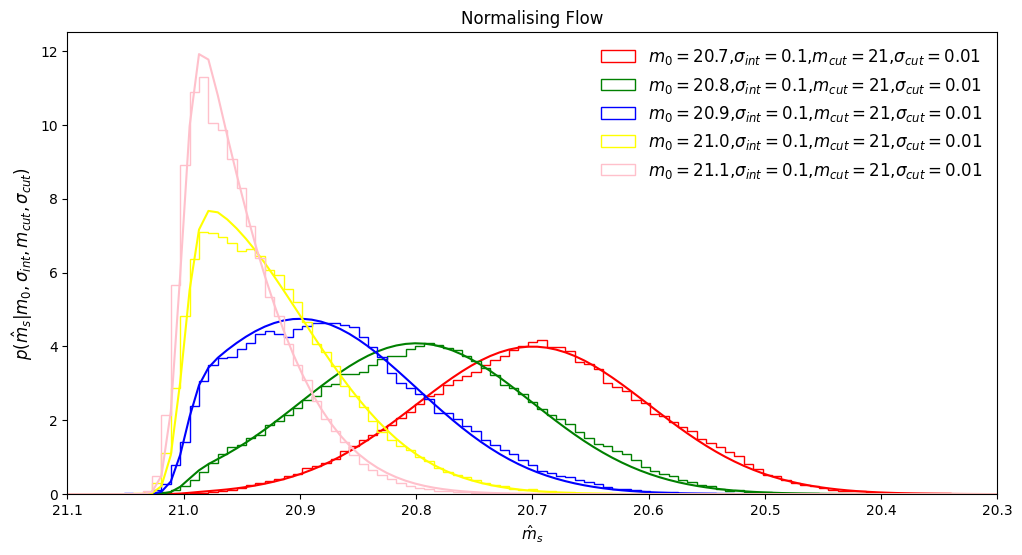

In [9]:
from matplotlib import pyplot as plt
c=['red','green','blue','yellow','pink']
mm = np.array([20.7,20.8,20.9,21,21.1])
bins=np.linspace(20.3,21.1,100)
no_samps = 100000


plt.figure(figsize=(12,6))



for i,m in enumerate(mm):
    

    samp=sample(rng, params,minmax_scale(np.column_stack((np.repeat(np.array([m]),no_samps).reshape(no_samps,1),np.array([0.1]*no_samps).reshape(no_samps,1))),min[1:],max[1:]),no_samps)
            
    samp = minmax_unscale(samp[:,0],min[0],max[0])


    plt.hist(samp,density=True,bins=bins,color=c[i],histtype='step',label='$m_0=$'+str(m)+',$\sigma_{int}=$'+str('0.1')+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))
    s=snp(np.array([m]),np.array([0.1]),21,0.01)
    plt.plot(bins,np.exp(s.log_prob(bins)),color=c[i])
    
    print(np.min(samp),np.max(samp))

    #plt.hist(s.sample(rng,(1000,1)).reshape(1000,),density=True,histtype='step')
    

plt.legend(loc='upper right',frameon=False,fontsize=12)
plt.xlabel('$\hat{m}_s$',fontsize=11)
plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
plt.title('Normalising Flow',fontsize=12)
plt.xlim(21.1,20.3)
plt.show()

13.09212227084368 25.415453048130196
13.097499255120287 25.44090346011799
13.106478731210753 25.46408855999782
13.123590520732078 25.475190205538883
13.146297672437173 25.48811971972384


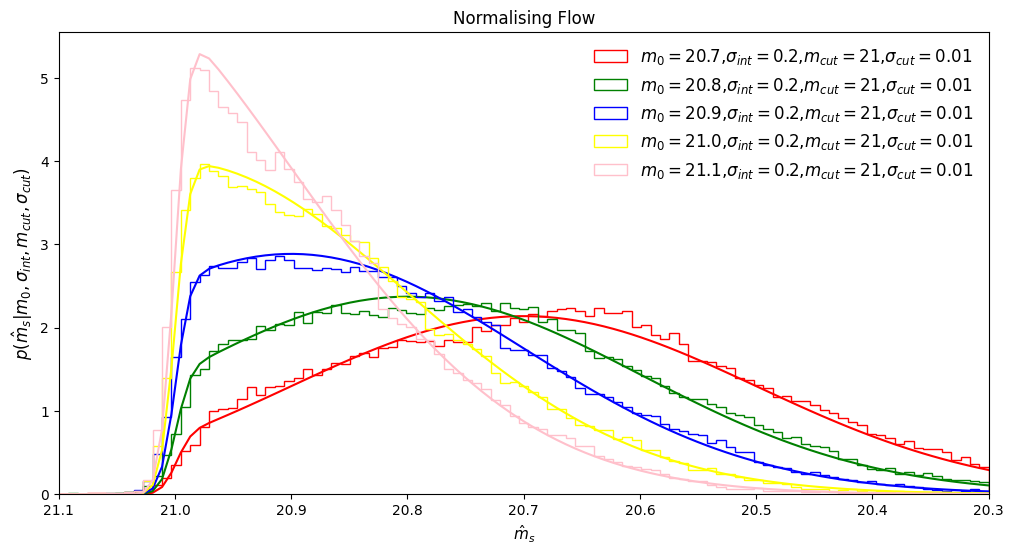

In [10]:
from matplotlib import pyplot as plt
c=['red','green','blue','yellow','pink']
mm = np.array([20.7,20.8,20.9,21,21.1])
bins=np.linspace(20.3,21.1,100)
no_samps = 100000


plt.figure(figsize=(12,6))



for i,m in enumerate(mm):
    

    samp=sample(rng, params,minmax_scale(np.column_stack((np.repeat(np.array([m]),no_samps).reshape(no_samps,1),np.array([0.2]*no_samps).reshape(no_samps,1))),min[1:],max[1:]),no_samps)
            
    samp = minmax_unscale(samp[:,0],min[0],max[0])


    plt.hist(samp,density=True,bins=bins,color=c[i],histtype='step',label='$m_0=$'+str(m)+',$\sigma_{int}=$'+str('0.2')+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))
    s=snp(np.array([m]),np.array([0.2]),21,0.01)
    plt.plot(bins,np.exp(s.log_prob(bins)),color=c[i])
    
    print(np.min(samp),np.max(samp))

    #plt.hist(s.sample(rng,(1000,1)).reshape(1000,),density=True,histtype='step')
    

plt.legend(loc='upper right',frameon=False,fontsize=12)
plt.xlabel('$\hat{m}_s$',fontsize=11)
plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
plt.title('Normalising Flow',fontsize=12)
plt.xlim(21.1,20.3)
plt.show()

13.324538856354884 25.226195602247863
13.394331944075104 25.25807703212049
13.383529477310754 25.355000696934525
13.422068577920221 25.409426475222244
13.493427927125088 25.40774592121113


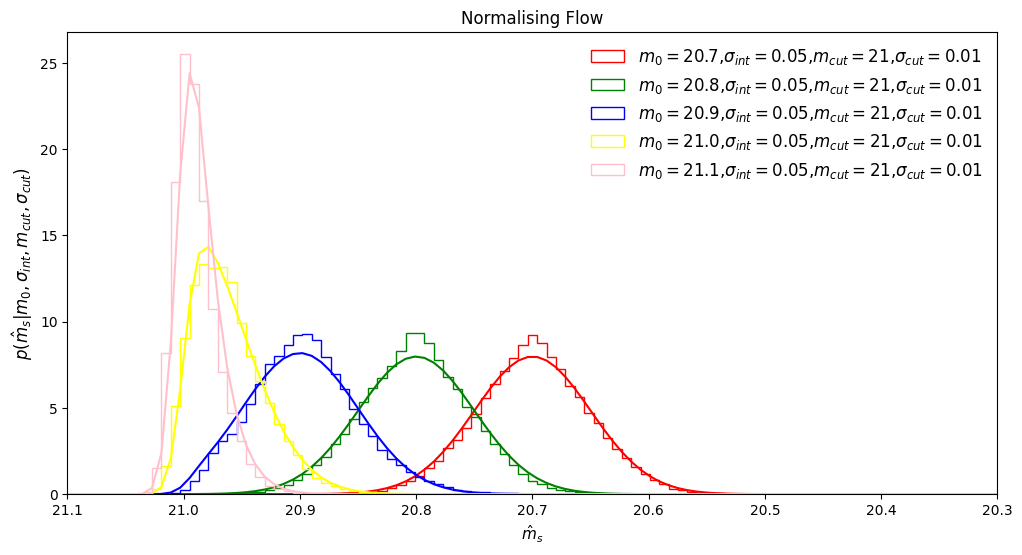

In [11]:
from matplotlib import pyplot as plt
c=['red','green','blue','yellow','pink']
mm = np.array([20.7,20.8,20.9,21,21.1])
bins=np.linspace(20.3,21.1,100)
no_samps = 100000


plt.figure(figsize=(12,6))



for i,m in enumerate(mm):
    

    samp=sample(rng, params,minmax_scale(np.column_stack((np.repeat(np.array([m]),no_samps).reshape(no_samps,1),np.array([0.05]*no_samps).reshape(no_samps,1))),min[1:],max[1:]),no_samps)
            
    samp = minmax_unscale(samp[:,0],min[0],max[0])


    plt.hist(samp,density=True,bins=bins,color=c[i],histtype='step',label='$m_0=$'+str(m)+',$\sigma_{int}=$'+str('0.05')+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))
    s=snp(np.array([m]),np.array([0.05]),21,0.01)
    plt.plot(bins,np.exp(s.log_prob(bins)),color=c[i])
    
    print(np.min(samp),np.max(samp))

    #plt.hist(s.sample(rng,(1000,1)).reshape(1000,),density=True,histtype='step')
    

plt.legend(loc='upper right',frameon=False,fontsize=12)
plt.xlabel('$\hat{m}_s$',fontsize=11)
plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
plt.title('Normalising Flow',fontsize=12)
plt.xlim(21.1,20.3)
plt.show()

13.569183873395131 25.015938754796586
13.670492042175798 25.084158467951596
13.674696414058714 25.17977282752839
13.775068697442226 25.269984284301557
13.91313205753271 25.213754550012933


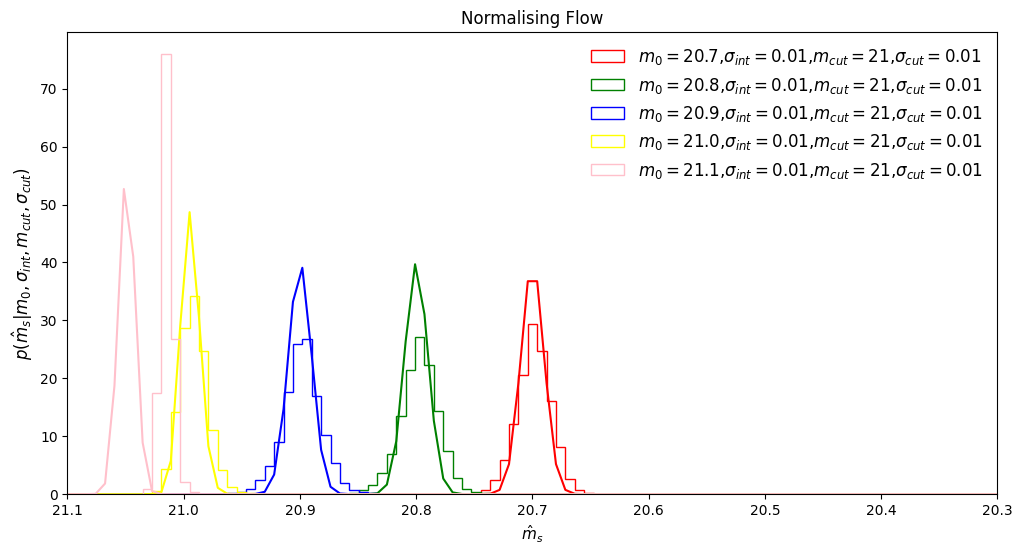

In [12]:
from matplotlib import pyplot as plt
c=['red','green','blue','yellow','pink']
mm = np.array([20.7,20.8,20.9,21,21.1])
bins=np.linspace(20.3,21.1,100)
no_samps = 100000


plt.figure(figsize=(12,6))



for i,m in enumerate(mm):
    

    samp=sample(rng, params,minmax_scale(np.column_stack((np.repeat(np.array([m]),no_samps).reshape(no_samps,1),np.array([0.01]*no_samps).reshape(no_samps,1))),min[1:],max[1:]),no_samps)
            
    samp = minmax_unscale(samp[:,0],min[0],max[0])


    plt.hist(samp,density=True,bins=bins,color=c[i],histtype='step',label='$m_0=$'+str(m)+',$\sigma_{int}=$'+str('0.01')+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))
    s=snp(np.array([m]),np.array([0.01]),21,0.01)
    plt.plot(bins,np.exp(s.log_prob(bins)),color=c[i])
    
    print(np.min(samp),np.max(samp))

    #plt.hist(s.sample(rng,(1000,1)).reshape(1000,),density=True,histtype='step')
    

plt.legend(loc='upper right',frameon=False,fontsize=12)
plt.xlabel('$\hat{m}_s$',fontsize=11)
plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
plt.title('Normalising Flow',fontsize=12)
plt.xlim(21.1,20.3)
plt.show()